In [16]:
!pip install openslide-python
!pip install openslide-bin


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
ERROR: Operation cancelled by user
^C

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [10]:
# Cell 1: Import Libraries
import os
import random
import openslide
from openslide import OpenSlideError
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt
import time

print("Libraries imported successfully.")

Libraries imported successfully.


In [11]:
# Cell 2: Set Parameters
# --- Input/Output ---
svs_file_path = "/mnt/data/zruan/GastricDetection/example/18IST10805R A17.svs"  # <--- *** SET THIS PATH ***
output_directory = "/mnt/data/zruan/GastricDetection/patches"      # <--- Set your desired output folder

# --- Patch Extraction Parameters ---
target_level = 0  # Level 0 is typically the highest resolution (e.g., 40x)
patch_width = 256 # Desired patch width in pixels at the target_level
patch_height = 256 # Desired patch height in pixels at the target_level
num_patches = 5   # Number of patches to extract

# --- Optional: Settings for avoiding background patches ---
perform_background_check = True # Set to True to try and skip blank/background areas
background_threshold = 225 # Pixel intensity threshold (0-255). Higher values skip lighter areas. Adjust based on staining.
background_check_downsample = 16 # Factor to downsample patch for faster background check. 1 means no downsample.

# --- Optional: Display settings ---
display_samples = True # Set to True to show a few generated patches at the end
num_samples_to_display = 5 # How many samples to show if display_samples is True

print("Parameters set.")
print(f"SVS File: {svs_file_path}")
print(f"Output Directory: {output_directory}")
print(f"Target Level: {target_level}")
print(f"Patch Size: {patch_width}x{patch_height}")
print(f"Number of Patches: {num_patches}")
print(f"Perform Background Check: {perform_background_check}")
if perform_background_check:
    print(f"  Background Threshold: {background_threshold}")
    print(f"  Background Check Downsample: {background_check_downsample}")

Parameters set.
SVS File: /mnt/data/zruan/GastricDetection/example/18IST10805R A17.svs
Output Directory: /mnt/data/zruan/GastricDetection/patches
Target Level: 0
Patch Size: 256x256
Number of Patches: 5
Perform Background Check: True
  Background Threshold: 225
  Background Check Downsample: 16


In [12]:
# Cell 3: Load SVS File and Validate Parameters

slide = None
try:
    print(f"Loading SVS file: {svs_file_path}...")
    start_time = time.time()
    slide = openslide.OpenSlide(svs_file_path)
    load_time = time.time() - start_time
    print(f"File loaded successfully in {load_time:.2f} seconds.")

    # --- Display Slide Information ---
    print("\n--- Slide Information ---")
    print(f"Level Count: {slide.level_count}")
    print(f"Level Dimensions: {slide.level_dimensions}")
    print(f"Level Downsamples: {slide.level_downsamples}")
    try:
        objective_power = slide.properties.get(openslide.PROPERTY_NAME_OBJECTIVE_POWER)
        if objective_power:
            print(f"Objective Power: {objective_power}x")
        mpp_x = slide.properties.get(openslide.PROPERTY_NAME_MPP_X)
        mpp_y = slide.properties.get(openslide.PROPERTY_NAME_MPP_Y)
        if mpp_x and mpp_y:
            print(f"Microns Per Pixel (MPP X, Y): {float(mpp_x):.4f}, {float(mpp_y):.4f}")
    except Exception as e:
        print(f"Could not read some metadata properties: {e}")

    # --- Validate Parameters ---
    if not (0 <= target_level < slide.level_count):
        raise ValueError(f"Error: target_level ({target_level}) is out of range. Available levels: 0 to {slide.level_count - 1}")

    level_dims = slide.level_dimensions[target_level]
    if patch_width > level_dims[0] or patch_height > level_dims[1]:
        raise ValueError(f"Error: Patch size ({patch_width}x{patch_height}) is larger than the dimensions "
                         f"at target_level {target_level} ({level_dims[0]}x{level_dims[1]})")

    if patch_width <= 0 or patch_height <= 0:
        raise ValueError("Error: Patch width and height must be positive.")

    if num_patches <= 0:
        raise ValueError("Error: Number of patches must be positive.")

except OpenSlideError as e:
    print(f"Error loading SVS file: {e}")
    slide = None
except ValueError as e:
    print(e)
    slide = None # Prevent proceeding if parameters are invalid
except FileNotFoundError:
    print(f"Error: SVS file not found at {svs_file_path}")
    slide = None
except Exception as e:
    print(f"An unexpected error occurred during loading or validation: {e}")
    slide = None

Loading SVS file: /mnt/data/zruan/GastricDetection/example/18IST10805R A17.svs...
File loaded successfully in 0.02 seconds.

--- Slide Information ---
Level Count: 4
Level Dimensions: ((118912, 88059), (29728, 22014), (7432, 5503), (1858, 1375))
Level Downsamples: (1.0, 4.000068138457346, 16.000999454842812, 64.02145454545455)
Objective Power: 40x
Microns Per Pixel (MPP X, Y): 0.2623, 0.2623


In [13]:
# Cell 4: Create Output Directory

if slide: # Proceed only if slide loaded successfully
    try:
        os.makedirs(output_directory, exist_ok=True)
        print(f"Output directory '{output_directory}' ensured.")
    except OSError as e:
        print(f"Error creating output directory '{output_directory}': {e}")
        # Stop execution if directory cannot be created
        slide = None

Output directory '/mnt/data/zruan/GastricDetection/patches' ensured.


In [14]:
# Cell 5: Define Background Check Function (Optional)

def is_background(patch_img, threshold, check_downsample=1):
    """
    Checks if a PIL image patch is likely background.
    Converts to grayscale, optionally downsamples, and checks mean intensity.
    """
    if patch_img is None:
        return True

    try:
        # Downsample for faster check if requested
        if check_downsample > 1:
             thumb_w = max(1, patch_img.width // check_downsample)
             thumb_h = max(1, patch_img.height // check_downsample)
             check_img = patch_img.resize((thumb_w, thumb_h), Image.Resampling.LANCZOS)
        else:
             check_img = patch_img

        # Convert to grayscale and calculate mean intensity
        gray_img = check_img.convert('L')
        mean_intensity = np.mean(np.array(gray_img))

        # If mean intensity is above threshold, consider it background
        return mean_intensity >= threshold
    except Exception as e:
        # print(f"Warning: Error during background check: {e}")
        return False # Default to not background if check fails

In [15]:
# Cell 6: Extract Patches

saved_patch_paths = []
if slide: # Proceed only if slide loaded and output directory is ready
    print("\nStarting patch extraction...")
    start_ext_time = time.time()

    target_dims = slide.level_dimensions[target_level]
    level0_dims = slide.level_dimensions[0]
    downsample_factor = slide.level_downsamples[target_level]

    generated_count = 0
    attempts = 0
    max_attempts = num_patches * 10 # Allow more attempts, especially if background check is strict

    while generated_count < num_patches and attempts < max_attempts:
        attempts += 1

        # Generate random top-left coordinates at the *target* level
        # Ensure the patch fits within the target level dimensions
        max_x_coord = target_dims[0] - patch_width
        max_y_coord = target_dims[1] - patch_height

        if max_x_coord < 0 or max_y_coord < 0:
             # Should have been caught by validation, but double-check
             print("Error: Cannot generate coordinates, patch size likely too large for level.")
             break

        random_x_target = random.randint(0, max_x_coord)
        random_y_target = random.randint(0, max_y_coord)

        # Convert target level coordinates to level 0 coordinates for read_region
        level0_x = int(random_x_target * downsample_factor)
        level0_y = int(random_y_target * downsample_factor)

        try:
            # Read the region from the slide
            patch = slide.read_region((level0_x, level0_y), target_level, (patch_width, patch_height))

            # Ensure patch is RGB (discard alpha channel if present)
            patch_rgb = patch.convert('RGB')

            # Optional: Perform background check
            is_bg = False
            if perform_background_check:
                is_bg = is_background(patch_rgb, background_threshold, background_check_downsample)

            if not is_bg:
                # Construct filename
                # Using level 0 coordinates in filename for consistency if comparing across levels later
                # Or use target level coords: filename = f"patch_L{target_level}_Tx{random_x_target}_Ty{random_y_target}.png"
                filename = f"patch_L{target_level}_L0x{level0_x}_L0y{level0_y}_W{patch_width}_H{patch_height}.png"
                filepath = os.path.join(output_directory, filename)

                # Save the patch
                patch_rgb.save(filepath)
                saved_patch_paths.append(filepath)
                generated_count += 1

                # Print progress occasionally
                if generated_count % 10 == 0 or generated_count == num_patches:
                    print(f"  Generated {generated_count}/{num_patches} patches... (Attempt {attempts})")

            # else:
                # Optional: print a message if a patch was skipped due to background check
                # print(f"  Skipped background patch at L0:({level0_x},{level0_y})")

        except openslide.OpenSlideError as e:
            print(f"Warning: OpenSlide error reading region at L0:({level0_x},{level0_y}): {e}")
        except Exception as e:
            print(f"Warning: Unexpected error processing patch at L0:({level0_x},{level0_y}): {e}")


    # --- Summary ---
    end_ext_time = time.time()
    print("\n--- Extraction Summary ---")
    if generated_count == num_patches:
        print(f"Successfully generated and saved {generated_count} patches.")
    else:
        print(f"Warning: Only generated {generated_count}/{num_patches} patches after {attempts} attempts.")
        if perform_background_check:
            print("  This might be due to a large background area or a strict background threshold.")
    print(f"Total extraction time: {end_ext_time - start_ext_time:.2f} seconds.")
    print(f"Patches saved in: {os.path.abspath(output_directory)}")

    # Close the slide object when done
    slide.close()
    print("Slide object closed.")
else:
    print("\nPatch extraction skipped because the SVS file was not loaded successfully or output directory failed.")


Starting patch extraction...
  Generated 5/5 patches... (Attempt 7)

--- Extraction Summary ---
Successfully generated and saved 5 patches.
Total extraction time: 1.64 seconds.
Patches saved in: /mnt/data/zruan/GastricDetection/patches
Slide object closed.



Displaying up to 5 sample patches...


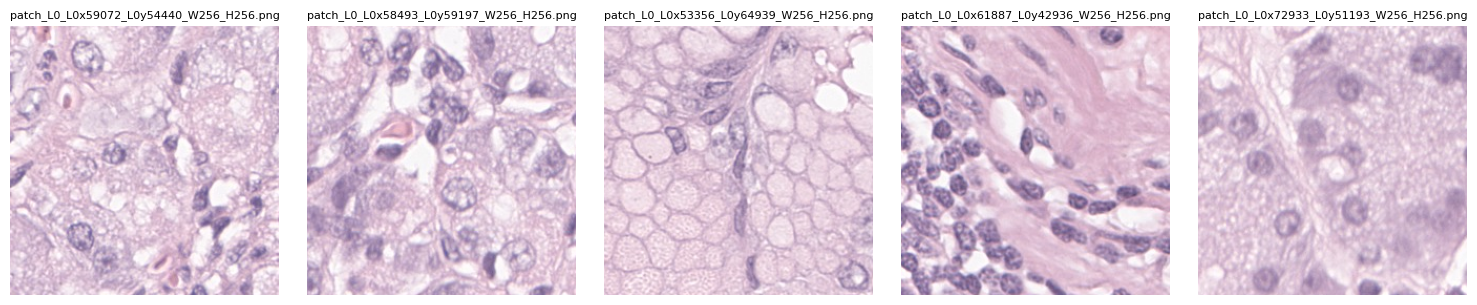

In [17]:
# Cell 7: Display Sample Patches (Optional)

# <--- ADD THIS SECTION --->
from PIL import PngImagePlugin
# Increase the limit for text chunk size (e.g., to 50MB or more if needed)
# The default is often 1MB (1024*1024). Adjust the value as necessary.
PngImagePlugin.MAX_TEXT_CHUNK = 50 * 1024 * 1024
# <--- END OF ADDED SECTION --->

if display_samples and saved_patch_paths:
    print(f"\nDisplaying up to {num_samples_to_display} sample patches...")

    num_to_show = min(num_samples_to_display, len(saved_patch_paths))
    sample_indices = random.sample(range(len(saved_patch_paths)), num_to_show)

    cols = min(num_to_show, 5) # Display up to 5 columns
    rows = math.ceil(num_to_show / cols)
    plt.figure(figsize=(cols * 3, rows * 3)) # Adjust figure size as needed

    for i, index in enumerate(sample_indices):
        img_path = saved_patch_paths[index]
        try:
            # Now Image.open should work with the increased limit
            img = Image.open(img_path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.title(os.path.basename(img_path), fontsize=8) # Show filename as title
            plt.axis('off')
        except openslide.OpenSlideError as ose:
             # It's unlikely OpenSlideError occurs here, but good practice
             print(f"OpenSlide error loading sample image {img_path}: {ose}")
        except Exception as e:
            # Catch other potential errors during loading/display
            print(f"Error loading/displaying sample image {img_path}: {e}")


    plt.tight_layout()
    plt.show()

elif display_samples:
    print("\nSample display skipped because no patches were saved.")